# Обучение базовое решение

## 1 Импорт библиотек, инициализация глобальных констант

### 1.1 Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
from colorama import Fore, Back, Style

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_percentage_error

import lightgbm as lgb
from lightgbm import log_evaluation

warnings.simplefilter('ignore')
pd.set_option('display.max_columns', None)

### 1.2 Инициализация констант

In [2]:
# целевая переменная
TARGET_NAME = 'Цена_квм'
# размер отложенной выборки
TEST_SIZE = 0.15
# random state для воспроизводимости
RANDOM_STATE = 42

## 2 Подготовка данных

In [3]:
df = pd.read_csv('houseprices_final.csv')
metros = pd.read_csv('metro_coords.csv')
df.head()

,ID,Ссылка,Цена,Дата,Адрес,Этаж,Количество_комнат,Балкон_или_лоджия,Тип_комнат,Общая_площадь,Жилая_площадь,Площадь_кухни,Высота_потолков,Санузел,Ремонт,Тип_дома,Год_постройки,Этажей_в_доме,Пассажирский_лифт,Грузовой_лифт,Метро_1,Метро_2,Метро_3,Расстояние_до_метро_1,Расстояние_до_метро_2,Расстояние_до_метро_3,Широта,Долгота,Ипотека,Расстояние_до_Кремля,Окна_на_улицу,Окна_во_двор,Окна_на_солнечную_сторону,Мебель_спальные_места,Мебель_кухня,Мебель_хранение_одежды,В_доме_мусоропровод,В_доме_консьерж,В_доме_газ,Двор_закрытая_территория,Двор_спортивная_площадка,Двор_детская_площадка,Парковка,Количество_лифтов,Цена_квм,Район,Общий_рейтинг,Экология,Чистота,ЖКХ,Соседи,Условия_для_детей,Спорт_и_отдых,Магазины,Транспорт,Безопасность,Стоимость_жизни,Суммарный рейтинг,Общая_площадь_отн_мин,Общая_площадь_минус_мин,Общая_площадь_отн_макс,Общая_площадь_минус_макс,Общая_площадь_отн_сред,Общая_площадь_минус_сред,Расстояние_до_Парк_культуры,Расстояние_до_Октябрьская,Расстояние_до_Добрынинская,Расстояние_до_Павелецкая,Расстояние_до_Таганская,Расстояние_до_Красные_ворота,Расстояние_до_Проспект_Мира,Расстояние_до_Курская,Расстояние_до_Белорусская,Расстояние_до_Новослободская,Расстояние_до_Киевская,Расстояние_до_Краснопресненская,Общая_площадь_кластер,Координаты_кластер
0,2636072348,https://avito.ru//moskva/kvartiry/3-k._kvartir...,33000000,2022-12-02,"Москва, Ленинградское шоссе, 69к2",18.0,3.0,балкон,изолированные,73.2,NaN,16.0,NaN,NaN,0.0,3.0,NaN,20.0,0,0,Беломорская,Речной вокзал,Планерная,30.0,30.0,31.0,55.868713,37.456819,0,16.417191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,450819.672131,45.0,39.0,39.0,84.0,65.0,38.0,44.0,40.0,102.0,81.0,17.0,23.0,572.0,1.763855,31.7,0.281538,-186.8,0.873901,-10.562326,17.083389,18.258180,18.672102,19.183695,18.657365,16.339909,14.839579,17.596692,12.816081,13.400078,15.492292,14.198571,8,40
1,2626697262,https://avito.ru//moskva/kvartiry/3-k._kvartir...,39000000,2022-12-03,"Москва, Ходынская улица, 2",13.0,3.0,NaN,изолированные,73.7,50.0,15.0,NaN,совмещенный,0.0,3.0,NaN,44.0,0,0,Улица 1905 года,Беговая,Белорусская,1905.0,20.0,20.0,55.770949,37.563930,0,3.971249,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,529172.320217,77.0,62.0,93.0,45.0,67.0,16.0,85.0,52.0,109.0,40.0,10.0,79.0,658.0,1.775904,32.2,0.283462,-186.3,0.879871,-10.062326,4.329917,5.493617,5.934142,6.548749,6.432229,5.254251,4.464546,6.107069,1.346540,2.524840,3.094803,1.435916,8,124
2,2658691692,https://avito.ru//moskva/kvartiry/3-k._kvartir...,22500000,2022-12-05,"Москва, Аминьевское ш., 4Дк3литБ",9.0,3.0,лоджия,изолированные,69.3,43.9,5.7,3.0,раздельный,3.0,3.0,2022.0,28.0,2,2,Аминьевская,Давыдково,Мичуринский проспект,15.0,30.0,31.0,55.698791,37.468364,1,11.067722,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,1.0,1.0,1.0,4,324675.324675,72.0,93.0,76.0,62.0,62.0,76.0,88.0,112.0,96.0,107.0,77.0,94.0,943.0,1.669880,27.8,0.266538,-190.7,0.827341,-14.462326,8.955781,9.558359,10.224293,11.210438,12.558108,13.636461,13.702383,13.664497,11.277326,12.245417,7.763103,9.657269,8,11
3,2515435010,https://avito.ru//moskva/kvartiry/3-k._kvartir...,17900000,2022-12-05,"Москва, Севастопольский пр-т, 13к2",5.0,3.0,лоджия,изолированные,62.5,45.0,7.0,2.8,совмещенный,1.0,4.0,1979.0,9.0,1,0,Крымская,Верхние Котлы,Нагатинская,15.0,20.0,20.0,55.683567,37.602962,0,7.665333,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1,286400.000000,38.0,53.0,36.0,22.0,53.0,78.0,62.0,71.0,37.0,16.0,47.0,113.0,588.0,1.506024,21.0,0.240385,-197.5,0.746159,-21.262326,5.869496,5.106472,5.197940,5.601104,7.262720,9.832084,10.848071,9.048621,10.519448,10.679586,7.054251,8.693040,0,10
4,1972516369,https://avito.ru//moskva/kvartiry/10_i_bolee-k...,525000000,2022-12-05,"Москва, Пресненская набережная, 6с2",59.0,1.0,NaN,изолированные,941.7,NaN,20.0,NaN,NaN,2.0,3.0,2010.0,60.0,1,0,Деловой центр,Выставочная,Международная,5.0,5.0,10.0,55.748071,37.540397,0,4.859495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,557502.389296,77.0,62.0,93.0,45.0,67.0,16.0,85.0,52.0,109

### 2.1 Кодирование станций метро

In [4]:
metro_stations = np.append(metros['Станция'].values, ['нет'])

le = LabelEncoder()

le.fit(metro_stations.reshape(-1, 1))
for i in range(1, 4):
    df[f'Метро_{i}'] = le.transform(df[f'Метро_{i}'])

### 2.2 Кодирование категориальных переменных

In [5]:
cat_features = [
    'Количество_комнат', 'Балкон_или_лоджия', 'Тип_комнат', 'Санузел',
    'Ремонт', 'Тип_дома', 'Район', 'Ипотека', 'Окна_во_двор',
    'Окна_на_солнечную_сторону', 'Окна_на_улицу', 'Мебель_спальные_места',
    'Мебель_кухня', 'Мебель_хранение_одежды', 'В_доме_консьерж',
    'В_доме_мусоропровод', 'В_доме_газ', 'Двор_детская_площадка',
    'Двор_закрытая_территория', 'Двор_спортивная_площадка', 'Парковка',
    'Общая_площадь_кластер', 'Координаты_кластер'
]

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df[cat_features] = encoder.fit_transform(df[cat_features])

### 2.3 Отложенная выборка

In [6]:
train, test = train_test_split(df,
                               test_size=TEST_SIZE,
                               stratify=df['Количество_комнат'],
                               random_state=RANDOM_STATE)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

## 3 Базовое решение
Базовое решение - сгруппируем данные на основе кластера координат и кластера общей площади и найдем медианную цену для каждой группы

In [7]:
baseline_preds = train.groupby(
    ['Общая_площадь_кластер', 'Координаты_кластер',
     'Количество_комнат'])['Цена_квм'].transform('median')

base_score = mean_absolute_percentage_error(train['Цена_квм'], baseline_preds)
print(f"MAPE: {base_score:.5f}")

MAPE: 0.16677


## 4 Обучение модели

### 4.1 Функция для обучения и получения предсказаний

In [8]:
def lgb_training(train_df, params, features, test_df=None, verbose=250):
    """
    Функция для обучения модели.
    
    Параметры
    ----------
    train_df - обучающая выборка
    params - набор гиперпараметров
    features - признаки
    test_df - тестовая выборка
    verbose - вывод результатов
    
    Возвращает
    -------
    score_list - MAPE на кросс-валидации для каждого фолда
    test_preds - предсказания на тестовой выборке, если тестовая выборка задана
    oof_preds - предсказания для обучающей выборки
    """
    test_preds = []
    if test_df is not None:
        test_preds = np.zeros(len(test_df))
        test_df = test_df[features]
    target = train_df.loc[:, TARGET_NAME].values

    categorical_feature = list(set(features) & set(cat_features))
    score_list = []
    oof_preds = np.zeros(len(target))

    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    for fold, (train_index, val_index) in enumerate(kf.split(train_df)):
        X_train = train_df.loc[train_index, features]
        X_val = train_df.loc[val_index, features]
        y_train = target[train_index]
        y_val = target[val_index]

        lgb_train = lgb.Dataset(X_train,
                                y_train,
                                categorical_feature=categorical_feature)
        lgb_valid = lgb.Dataset(X_val,
                                y_val,
                                categorical_feature=categorical_feature)

        callbacks = [lgb.log_evaluation(period=verbose)]
        model = lgb.train(params=params,
                          train_set=lgb_train,
                          num_boost_round=15000,
                          valid_sets=[lgb_train, lgb_valid],
                          categorical_feature=categorical_feature,
                          callbacks=callbacks)

        preds = model.predict(X_val)
        oof_preds[val_index] = preds
        score = mean_absolute_percentage_error(y_val, preds)

        if test_df is not None:
            test_preds += model.predict(test_df) / kf.n_splits

        if verbose:
            print(
                f"{Fore.BLACK}{Style.BRIGHT}FOLD: {fold}, MAPE: {score:.5f} {Style.RESET_ALL}"
            )
        score_list.append(score)

    return score_list, test_preds, oof_preds

In [9]:
params = {
    'objective': 'mape',
    'learning_rate': 0.3,
    'reg_lambda': 5,
    'random_state': 42,
    'early_stopping_rounds': 300,
    'feature_fraction': 0.4,
    'verbose': -1
}

Обучим модель на всех доступных признаках

In [10]:
features_to_drop = ['ID', 'Ссылка', 'Цена', 'Дата', 'Адрес', 'Цена_квм']
features = [f for f in df.columns if f not in features_to_drop]

In [11]:
score_list, test_preds, oof_preds = lgb_training(train,
                                                 params,
                                                 features,
                                                 test,
                                                 verbose=500)
test_score = mean_absolute_percentage_error(test[TARGET_NAME], test_preds)

print(f"{Fore.GREEN}{Style.BRIGHT}\nMAPE на кросс-валидации:", end=' ')
print(f"{np.mean(score_list):.5f} +- {np.std(score_list):.5f}")

print(f"{Fore.RED}MAPE на тестовой выборке: {test_score:.5f}{Style.RESET_ALL}")

[500]	training's mape: 0.080043	valid_1's mape: 0.131872
[1000]	training's mape: 0.0722683	valid_1's mape: 0.130537
[1500]	training's mape: 0.0678944	valid_1's mape: 0.129813
[2000]	training's mape: 0.0652925	valid_1's mape: 0.129572
[2500]	training's mape: 0.0630844	valid_1's mape: 0.129236
[3000]	training's mape: 0.0614845	valid_1's mape: 0.12883
[3500]	training's mape: 0.059996	valid_1's mape: 0.128665
[4000]	training's mape: 0.058906	valid_1's mape: 0.128547
[4500]	training's mape: 0.0580508	valid_1's mape: 0.128417
[5000]	training's mape: 0.0571757	valid_1's mape: 0.128256
FOLD: 0, MAPE: 0.12825 
[500]	training's mape: 0.0794012	valid_1's mape: 0.127463
[1000]	training's mape: 0.0707812	valid_1's mape: 0.125821
[1500]	training's mape: 0.0664272	valid_1's mape: 0.12488
[2000]	training's mape: 0.0637283	valid_1's mape: 0.124433
[2500]	training's mape: 0.0616707	valid_1's mape: 0.123898
[3000]	training's mape: 0.0602128	valid_1's mape: 0.123633
[3500]	training's mape: 0.0591372	valid

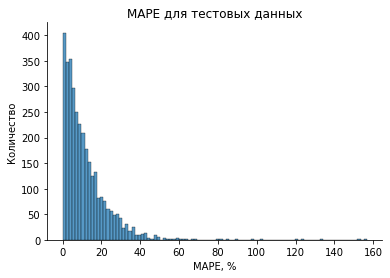

In [12]:
sns.histplot(np.abs(test[TARGET_NAME] - test_preds) / test[TARGET_NAME] * 100)
plt.title("MAPE для тестовых данных")
plt.xlabel("MAPE, %")
plt.ylabel("Количество")
sns.despine()
plt.show()